In [73]:
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy
from scipy import io
from tqdm import tqdm_notebook as tqdm

In [74]:
# functions

def f_x(state, dt):
    Glucose_history[k-1] = state[1]
    h = 5 
    Insulin = state[0]
    Glucose = state[1]
    #rate of glucose appearance
    R_a = state[2] 
    R_a_neg_1 = state[3]
    p1 = state[4]
    p2 = state[5]
    p4 = state[6]
    tao = state[7]

    #not belonging to the state
    w = np.random.normal(1) 
    Ip = 0 + w
    C = 0 + w
    p3 = 0 + w
    V = 0 + w

    #insulin concentration at next step
    insulin_conc_next = (h * (p2 * (Insulin/(h * p2) - Insulin))) + (p3 * Ip)

    # R_a at next step
    a = np.exp((h/tao))
    R_a_next = ((h * C) / (V * a * tao)) + ((2 * R_a) / a) - (R_a_neg_1 / a ** 2)

    # calculating basal plasma glucose concentration
    if k < 12:
        Glucose_basal = 100
    else:
        Glucose_sum = 0
        for i in range(k-11, k-5, 1):
            Glucose_sum += Glucose_history[i]
        Glucose_basal = (1/6) * Glucose_sum
    
    # Glucose_concentration at next step
    Glucose_next = h * ((p1 * (Glucose_basal + (Glucose / (h * p1)) - Glucose)) - (p2 * Insulin * Glucose) + R_a)

    # next step values
    R_a_neg_1_next = R_a
    p1_next = p1
    p2_next = p2
    p4_next = p4
    tao_next = tao

    state_next = [
        insulin_conc_next,
        Glucose_next,
        R_a_next,
        R_a_neg_1_next,
        p1_next,
        p2_next,
        p4_next,
        tao_next
    ]
    return state_next


def y_x(state):
    return np.array([state[1]])

In [75]:
#read the data from the csv 
kalman_data = pd.read_csv('kalman_filter.csv', parse_dates=['dateMuBolus', 'dateNumber'])
kalman_data =kalman_data[~kalman_data.isin([np.nan, np.inf, -np.inf]).any(1)]
kalman_data = kalman_data.dropna()
kalman_data = kalman_data.reset_index(drop=True)

In [76]:
#process data for kalman filtering input
kalman_data1 = kalman_data['numCGM']
num_train_data = 500
start = np.random.randint(0, len(kalman_data1) - num_train_data)
end = start + num_train_data
train_data = kalman_data1[start : end].to_numpy()

In [77]:
#set random seed
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

In [78]:
#initialize inputs for unscented filter based on the research paper
dt = 5
sigma_points = MerweScaledSigmaPoints(8, alpha=1, beta=2, kappa=0)
kf = UnscentedKalmanFilter(dim_x=8, dim_z=1, dt=dt, fx=f_x, hx=y_x, points=sigma_points)
kf.x = np.array([0, train_data[0], 0, 0, 0.068, 0.037, 1.3, 20]) 
kf.R = np.array([100])
kf.Q = np.diag([1e-06, 1e-06, 1e-03, 1e-03, 1e-02, 1e-01, 1e-02, 1e-01])

In [79]:
# prediction and updates
difference = []
R_a = []
k = 1
Glucose_history = [0 for _ in range(len(train_data))]
Glucose_history[0] = train_data[0]
for y in train_data[1:]:
    kf.predict()
    difference.append((kf.x[1], y))
    R_a.append(kf.x[2])
    kf.update(y)
    k += 1
difference = np.array(difference)

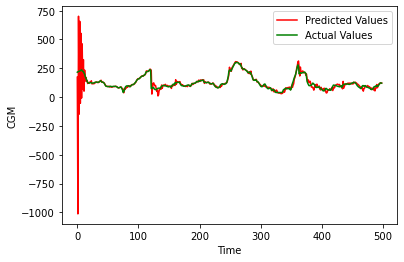

In [80]:
# Actual vs. predictd CGM
plt.plot(difference[:, 0], label='Predicted Values', color='red')
plt.plot(difference[:, 1], label='Actual Values', color='green')
plt.ylabel('CGM')
plt.xlabel('Time')
plt.legend()
plt.show()

Text(0, 0.5, 'R_a values')

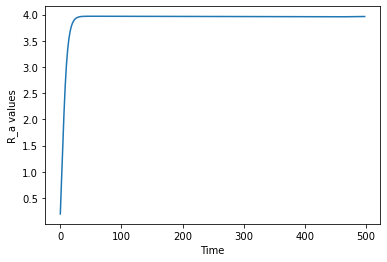

In [81]:
# Plotting R_a : there's no distinction between meal and no-meal
plt.plot(R_a)
plt.xlabel('Time')
plt.ylabel('R_a values')

In [82]:
# Threshold residue to detect meal
meal_from_cgm = data
meal_start = meal_from_cgm.loc[meal_from_cgm['start_of_meal']==1].index.tolist()
meal_idx_30 = meal_from_cgm.loc[meal_from_cgm['meal']==1].index.tolist()
meal_idx = np.concatenate((meal_start,meal_idx_30),axis=0).tolist()
non_meal_idx = meal_from_cgm.loc[(meal_from_cgm['meal']==0) & (meal_from_cgm['start_of_meal']==0) ].index.tolist()

In [83]:
# meal prediction parameters, 1: meal, 0: no meal

num_meal = 800
num_non_meal = 1500
num_train = 500

rand_meal_idx = random.sample(meal_idx, num_meal)
rand_non_meal_idx = random.sample(non_meal_idx, num_non_meal)

Depict = [(rand_meal_idx,'1'),(rand_non_meal_idx,'0')]

meal_difference = []
non_meal_difference = []

In [86]:
# Prediction using Kalman
for d in Depict:
    for num, i in enumerate(d[0]):
        if d[1] == '1':
            print(num+1, " / ", num_meal, "Random Meal point")
        else:
            print(num+1," / ", num_non_meal, "Random Non Meal point")
            
        if(i >= num_train):
            start_idx = i - num_train
            non_meal_points = meal_from_cgm.loc[meal_from_cgm['meal']==0]
            non_meal_points = non_meal_points.loc[start_idx:i].index
            train = meal_from_cgm['numCGM'].loc[non_meal_points].values
        else:
            start_idx = 0
            non_meal_points = meal_from_cgm.loc[meal_from_cgm['meal']==0]
            non_meal_points = non_meal_points.loc[start_idx:i].index
            train = meal_from_cgm['numCGM'].loc[non_meal_points].values

        dt = 5 
        sigma_points = MerweScaledSigmaPoints(8, alpha=1, beta=2, kappa=0)
        kf = UnscentedKalmanFilter(dim_x=8, dim_z=1, dt=dt, fx=f_x, hx=y_x, points=sigma_points)
        kf.x = np.array([0, train[0], 0, 0, 0.068, 0.037, 1.3, 20]) 
        kf.R = np.array([100])
        kf.Q = np.diag([1e-06, 1e-06, 1e-03, 1e-03, 1e-02, 1e-01, 1e-02, 1e-01])

        difference = []
        k = 1
        Glucose_history = [0 for _ in range(len(train))]
        Glucose_history[0] = train[0]
        flag = True
        for y in train[1:]:
            try:
                kf.predict()
                difference.append((kf.x[1], y))
                kf.update(y)
                k += 1
            except Exception:
                flag = False
        difference = np.array(difference)
       
        try:
            kf.predict()
            meal_prediction = kf.x[1]
        except Exception:
            flag = False
    
        if flag:
            if(d[1] == '1'):
                meal_difference.append(abs(meal_prediction - meal_from_cgm['numCGM'].loc[i]))
            else:
                non_meal_difference.append(abs(meal_prediction - meal_from_cgm['numCGM'].loc[i]))
        else:
            print("No Prediction for this point")

meal_difference = np.array(meal_difference)
non_meal_difference = np.array(non_meal_difference)

1  /  800 Random Meal point
2  /  800 Random Meal point
3  /  800 Random Meal point
4  /  800 Random Meal point
5  /  800 Random Meal point
6  /  800 Random Meal point
7  /  800 Random Meal point
8  /  800 Random Meal point
9  /  800 Random Meal point
10  /  800 Random Meal point
11  /  800 Random Meal point
12  /  800 Random Meal point
13  /  800 Random Meal point
14  /  800 Random Meal point
15  /  800 Random Meal point
16  /  800 Random Meal point
17  /  800 Random Meal point
18  /  800 Random Meal point
19  /  800 Random Meal point
20  /  800 Random Meal point
21  /  800 Random Meal point
22  /  800 Random Meal point
23  /  800 Random Meal point
24  /  800 Random Meal point
25  /  800 Random Meal point
26  /  800 Random Meal point
27  /  800 Random Meal point
28  /  800 Random Meal point
29  /  800 Random Meal point
30  /  800 Random Meal point
31  /  800 Random Meal point
32  /  800 Random Meal point
33  /  800 Random Meal point
34  /  800 Random Meal point
35  /  800 Random Meal 

278  /  800 Random Meal point
279  /  800 Random Meal point
280  /  800 Random Meal point
281  /  800 Random Meal point
282  /  800 Random Meal point
283  /  800 Random Meal point
284  /  800 Random Meal point
285  /  800 Random Meal point
286  /  800 Random Meal point
287  /  800 Random Meal point
288  /  800 Random Meal point
289  /  800 Random Meal point
290  /  800 Random Meal point
291  /  800 Random Meal point
292  /  800 Random Meal point
293  /  800 Random Meal point
294  /  800 Random Meal point
295  /  800 Random Meal point
296  /  800 Random Meal point
297  /  800 Random Meal point
298  /  800 Random Meal point
299  /  800 Random Meal point
300  /  800 Random Meal point
301  /  800 Random Meal point
302  /  800 Random Meal point
303  /  800 Random Meal point
304  /  800 Random Meal point
305  /  800 Random Meal point
306  /  800 Random Meal point
307  /  800 Random Meal point
308  /  800 Random Meal point
309  /  800 Random Meal point
310  /  800 Random Meal point
311  /  80

553  /  800 Random Meal point
554  /  800 Random Meal point
555  /  800 Random Meal point
556  /  800 Random Meal point
557  /  800 Random Meal point
558  /  800 Random Meal point
559  /  800 Random Meal point
560  /  800 Random Meal point
561  /  800 Random Meal point
562  /  800 Random Meal point
563  /  800 Random Meal point
564  /  800 Random Meal point
565  /  800 Random Meal point
566  /  800 Random Meal point
567  /  800 Random Meal point
568  /  800 Random Meal point
569  /  800 Random Meal point
570  /  800 Random Meal point
571  /  800 Random Meal point
572  /  800 Random Meal point
573  /  800 Random Meal point
574  /  800 Random Meal point
575  /  800 Random Meal point
576  /  800 Random Meal point
577  /  800 Random Meal point
578  /  800 Random Meal point
579  /  800 Random Meal point
580  /  800 Random Meal point
581  /  800 Random Meal point
582  /  800 Random Meal point
583  /  800 Random Meal point
584  /  800 Random Meal point
585  /  800 Random Meal point
586  /  80

24  /  1500 Random Non Meal point
25  /  1500 Random Non Meal point
26  /  1500 Random Non Meal point
27  /  1500 Random Non Meal point
28  /  1500 Random Non Meal point
29  /  1500 Random Non Meal point
30  /  1500 Random Non Meal point
31  /  1500 Random Non Meal point
32  /  1500 Random Non Meal point
33  /  1500 Random Non Meal point
34  /  1500 Random Non Meal point
35  /  1500 Random Non Meal point
36  /  1500 Random Non Meal point
37  /  1500 Random Non Meal point
38  /  1500 Random Non Meal point
39  /  1500 Random Non Meal point
40  /  1500 Random Non Meal point
41  /  1500 Random Non Meal point
42  /  1500 Random Non Meal point
43  /  1500 Random Non Meal point
44  /  1500 Random Non Meal point
45  /  1500 Random Non Meal point
46  /  1500 Random Non Meal point
47  /  1500 Random Non Meal point
48  /  1500 Random Non Meal point
49  /  1500 Random Non Meal point
50  /  1500 Random Non Meal point
51  /  1500 Random Non Meal point
52  /  1500 Random Non Meal point
53  /  1500 Ra

261  /  1500 Random Non Meal point
262  /  1500 Random Non Meal point
263  /  1500 Random Non Meal point
264  /  1500 Random Non Meal point
265  /  1500 Random Non Meal point
266  /  1500 Random Non Meal point
267  /  1500 Random Non Meal point
268  /  1500 Random Non Meal point
269  /  1500 Random Non Meal point
270  /  1500 Random Non Meal point
271  /  1500 Random Non Meal point
272  /  1500 Random Non Meal point
273  /  1500 Random Non Meal point
274  /  1500 Random Non Meal point
275  /  1500 Random Non Meal point
276  /  1500 Random Non Meal point
277  /  1500 Random Non Meal point
278  /  1500 Random Non Meal point
279  /  1500 Random Non Meal point
280  /  1500 Random Non Meal point
281  /  1500 Random Non Meal point
282  /  1500 Random Non Meal point
283  /  1500 Random Non Meal point
284  /  1500 Random Non Meal point
285  /  1500 Random Non Meal point
286  /  1500 Random Non Meal point
287  /  1500 Random Non Meal point
288  /  1500 Random Non Meal point
289  /  1500 Random 

497  /  1500 Random Non Meal point
498  /  1500 Random Non Meal point
499  /  1500 Random Non Meal point
500  /  1500 Random Non Meal point
501  /  1500 Random Non Meal point
502  /  1500 Random Non Meal point
503  /  1500 Random Non Meal point
504  /  1500 Random Non Meal point
505  /  1500 Random Non Meal point
506  /  1500 Random Non Meal point
507  /  1500 Random Non Meal point
508  /  1500 Random Non Meal point
509  /  1500 Random Non Meal point
510  /  1500 Random Non Meal point
511  /  1500 Random Non Meal point
512  /  1500 Random Non Meal point
513  /  1500 Random Non Meal point
514  /  1500 Random Non Meal point
515  /  1500 Random Non Meal point
516  /  1500 Random Non Meal point
517  /  1500 Random Non Meal point
518  /  1500 Random Non Meal point
519  /  1500 Random Non Meal point
520  /  1500 Random Non Meal point
521  /  1500 Random Non Meal point
522  /  1500 Random Non Meal point
523  /  1500 Random Non Meal point
524  /  1500 Random Non Meal point
525  /  1500 Random 

732  /  1500 Random Non Meal point
733  /  1500 Random Non Meal point
734  /  1500 Random Non Meal point
735  /  1500 Random Non Meal point
736  /  1500 Random Non Meal point
737  /  1500 Random Non Meal point
738  /  1500 Random Non Meal point
739  /  1500 Random Non Meal point
740  /  1500 Random Non Meal point
741  /  1500 Random Non Meal point
742  /  1500 Random Non Meal point
743  /  1500 Random Non Meal point
744  /  1500 Random Non Meal point
745  /  1500 Random Non Meal point
746  /  1500 Random Non Meal point
747  /  1500 Random Non Meal point
748  /  1500 Random Non Meal point
749  /  1500 Random Non Meal point
750  /  1500 Random Non Meal point
751  /  1500 Random Non Meal point
752  /  1500 Random Non Meal point
753  /  1500 Random Non Meal point
754  /  1500 Random Non Meal point
755  /  1500 Random Non Meal point
756  /  1500 Random Non Meal point
757  /  1500 Random Non Meal point
758  /  1500 Random Non Meal point
759  /  1500 Random Non Meal point
760  /  1500 Random 

968  /  1500 Random Non Meal point
969  /  1500 Random Non Meal point
970  /  1500 Random Non Meal point
971  /  1500 Random Non Meal point
972  /  1500 Random Non Meal point
973  /  1500 Random Non Meal point
974  /  1500 Random Non Meal point
975  /  1500 Random Non Meal point
976  /  1500 Random Non Meal point
977  /  1500 Random Non Meal point
No Prediction for this point
978  /  1500 Random Non Meal point
979  /  1500 Random Non Meal point
980  /  1500 Random Non Meal point
981  /  1500 Random Non Meal point
982  /  1500 Random Non Meal point
983  /  1500 Random Non Meal point
984  /  1500 Random Non Meal point
985  /  1500 Random Non Meal point
986  /  1500 Random Non Meal point
987  /  1500 Random Non Meal point
988  /  1500 Random Non Meal point
989  /  1500 Random Non Meal point
990  /  1500 Random Non Meal point
991  /  1500 Random Non Meal point
992  /  1500 Random Non Meal point
993  /  1500 Random Non Meal point
994  /  1500 Random Non Meal point
995  /  1500 Random Non Me

1197  /  1500 Random Non Meal point
1198  /  1500 Random Non Meal point
1199  /  1500 Random Non Meal point
1200  /  1500 Random Non Meal point
1201  /  1500 Random Non Meal point
1202  /  1500 Random Non Meal point
1203  /  1500 Random Non Meal point
1204  /  1500 Random Non Meal point
1205  /  1500 Random Non Meal point
1206  /  1500 Random Non Meal point
1207  /  1500 Random Non Meal point
1208  /  1500 Random Non Meal point
1209  /  1500 Random Non Meal point
1210  /  1500 Random Non Meal point
1211  /  1500 Random Non Meal point
1212  /  1500 Random Non Meal point
1213  /  1500 Random Non Meal point
1214  /  1500 Random Non Meal point
1215  /  1500 Random Non Meal point
1216  /  1500 Random Non Meal point
1217  /  1500 Random Non Meal point
1218  /  1500 Random Non Meal point
1219  /  1500 Random Non Meal point
1220  /  1500 Random Non Meal point
1221  /  1500 Random Non Meal point
1222  /  1500 Random Non Meal point
1223  /  1500 Random Non Meal point
1224  /  1500 Random Non Mea

1426  /  1500 Random Non Meal point
1427  /  1500 Random Non Meal point
1428  /  1500 Random Non Meal point
1429  /  1500 Random Non Meal point
1430  /  1500 Random Non Meal point
1431  /  1500 Random Non Meal point
1432  /  1500 Random Non Meal point
1433  /  1500 Random Non Meal point
1434  /  1500 Random Non Meal point
1435  /  1500 Random Non Meal point
1436  /  1500 Random Non Meal point
1437  /  1500 Random Non Meal point
1438  /  1500 Random Non Meal point
1439  /  1500 Random Non Meal point
1440  /  1500 Random Non Meal point
1441  /  1500 Random Non Meal point
1442  /  1500 Random Non Meal point
1443  /  1500 Random Non Meal point
1444  /  1500 Random Non Meal point
1445  /  1500 Random Non Meal point
1446  /  1500 Random Non Meal point
1447  /  1500 Random Non Meal point
1448  /  1500 Random Non Meal point
1449  /  1500 Random Non Meal point
1450  /  1500 Random Non Meal point
1451  /  1500 Random Non Meal point
1452  /  1500 Random Non Meal point
1453  /  1500 Random Non Mea

In [88]:
# remove outliers
def discard_outliers(data, val=2):
    return data[abs(data - np.mean(data)) < val * np.std(data)]

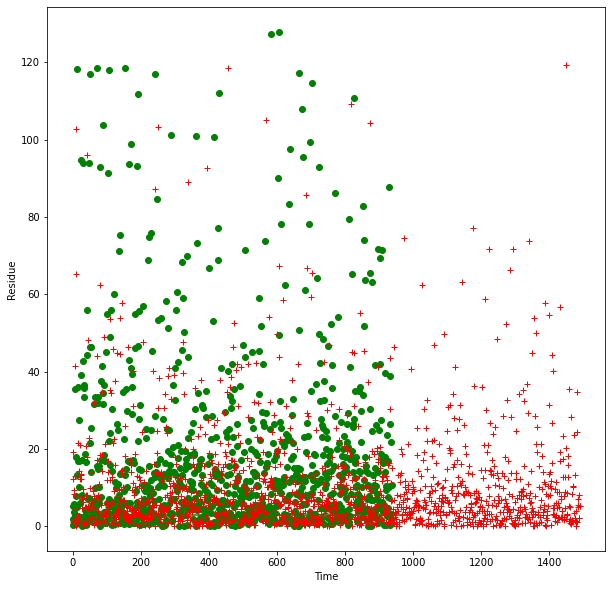

In [89]:
# residue values
plot_meal_difference = discard_outliers(meal_difference, 5)
plot_non_meal_difference = discard_outliers(non_meal_difference, 5)
plt.figure(figsize=(10, 10))
plt.plot(plot_meal_difference, 'o', color='green')
plt.plot(plot_non_meal_difference, '+', color='red')
plt.hlines(3.0, 0, 1000, color='green')
plt.xlabel('Time')
plt.ylabel('Residue')
plt.show()

In [92]:
# accuracy
threshold = 20 
non_meal = [non_meal_difference[non_meal_difference < threshold].__len__(), non_meal_difference[non_meal_difference >= threshold].__len__()]
meal = [meal_difference[meal_difference < threshold].__len__(), meal_difference[meal_difference >= threshold].__len__()]
TP = meal_difference[meal_difference >= threshold].__len__() / meal_difference.__len__()
TN = non_meal_difference[non_meal_difference < threshold].__len__() / non_meal_difference.__len__()
FP = non_meal_difference[non_meal_difference >= threshold].__len__() / non_meal_difference.__len__()
FN = meal_difference[meal_difference < threshold].__len__() / meal_difference.__len__()
correct_pred = non_meal_difference[non_meal_difference < threshold].__len__() + meal_difference[meal_difference >= threshold].__len__()
total = meal_difference.__len__() + non_meal_difference.__len__()
acc = (correct_pred) / (total)
print("Accuracy: ", acc)




Accuracy:  0.6307377049180328
